# Topic Modelling

<br>

## BERTopic Modelling Breakdown

- The BERTopic pipeline will be broken down in this notebook.

In [1]:
# Built-in library
import re
import json
from typing import Any, Optional, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
from pprint import pprint
import pandas as pd
import polars as pl
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data

In [2]:
from datasets import Dataset, load_dataset

path: str = "jamescalam/reddit-topics"
split: str = "train"

data: Dataset = load_dataset(path=path, split=split)
data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3791
})

In [3]:
print(data[:2])

{
    'sub': ['investing', 'investing'],
    'title': [
        "Followup- Here are the results so far from my algo's price calculations on the symbols you gave me:",
        'This 2 hr Mohnish Pabrai lecture is better than 90% of my Ivy League Investing Classes'
    ],
    'selftext': [
        "Please don't put any weight on these!  Its just for fun.  I made this algo myself..I don't know what I'm 
doing... its far more complicated than need be, and I don't even know what its doing anymore.\n\nNow I'm just 
testing it for the first time...and having some fun.\n\n|*Asset*|*Actual Price*|*Calculated Price*|*% 
Change*|\n|:-|:-|:-|:-|\n|FRLN|0.7522|0.114058535|\\-85%|\n|HYMC|1.43|0.921447084|\\-36%|\n|SQQQ|46.56|35.08529881|
\\-25%|\n|KOLD|8.78|7.087276735|\\-19%|\n|MOS|65.4|55.48180539|\\-15%|\n|UI|277.02|245.3351418|\\-11%|\n|AAL|19.14|
17.00989343|\\-11%|\n|TGT|232.7|210.6066256|\\-9%|\n|FLMN|6.86|6.398027457|\\-7%|\n|REGN|671.33|627.7051901|\\-6%|\
n|MSFT|285.65|268.8981373|\\-6%|\n|CC|32.64|31.09223336|\\-5%|\n|BHP|68|64.93559832|\\-5%|\n|KMB|140.48|135.0943617
|\\-4%|\n|ARCC|20.85|20.08539081|\\-4%|\n|PFE|49.86|48.10944975|\\-4%|\n|MAS|54.7|52.88982538|\\-3%|\n|GGB|5.63|5.4
50538112|\\-3%|\n|V|216|209.8209104|\\-3%|\n|TWTR|48.79|47.50760913|\\-3%|\n|TSLA|896|875.6372586|\\-2%|\n|STAG|39.
71|38.80885253|\\-2%|\n|ITOT|93.92|93.08233041|\\-1%|\n|GOOG|2326.92|2307.16525|\\-1%|\n|ROK|256.79|255.0798264|\\-
1%|\n|RDBX|3.4|3.382586899|\\-1%|\n|NOK|5.08|5.06265949|0%|\n|AAPL|158.77|158.3036962|0%|\n|BLL|81.01|81.36138508|0
%|\n|HI|40.74|41.39205932|2%|\n|ASO|37.51|38.27378177|2%|\n|BAC|36.5|37.39420669|2%|\n|MU|67.3|69.13824116|3%|\n|CS
CO|49.6|50.97448964|3%|\n|SCHY|24.39|25.14476674|3%|\n|AMD|86.3|89.50602306|4%|\n|HASI|40.56|42.43610909|5%|\n|TSM|
91.4|95.7883795|5%|\n|ADBE|403.27|422.9537504|5%|\n|ZIM|57.5|60.36086427|5%|\n|INTC|45.6|48.12631788|6%|\n|INTC|45.
6|48.12631788|6%|\n|JPM|122|128.921095|6%|\n|VZ|48.68|51.45133178|6%|\n|NET|92.87|98.281279|6%|\n|CBL|28|29.6949975
9|6%|\n|WBA|44.25|47.66109726|8%|\n|CELH|54|58.17653303|8%|\n|MMM|144.21|155.6670324|8%|\n|ATER|5.2|5.657450001|9%|
\n|SBUX|74.88|81.48248541|9%|\n|LUMN|10.5|11.48311605|9%|\n|HBI|13.7|15.00536269|10%|\n|DB|10.24|11.23550725|10%|\n
|FB|207.09|228.4724841|10%|\n|UBER|31.1999|34.49288882|11%|\n|ILMN|296.184|327.545313|11%|\n|GM|38.91|43.06569438|1
1%|\n|PKE|11.79|13.11316978|11%|\n|DIS|116.7|130.1778382|12%|\n|NVDA|188.3|211.9036967|13%|\n|IVT|30.57|34.41726576
|13%|\n|FL|29.6|33.67027133|14%|\n|UMC|7.85|8.940326714|14%|\n|OPY|32.15|36.90363169|15%|\n|AGNC|11.22|12.89140747|
15%|\n|GME|129.84|150.3780619|16%|\n|ETWO|7.5|8.799146294|17%|\n|T|19.13|22.65981112|18%|\n|CNF|3.1|3.682833415|19%
|\n|BGFV|15|17.83488333|19%|\n|RCUS|24.98|30.10472664|21%|\n|BBBY|14.85|18.05023732|22%|\n|SNDL|0.5325|0.649718687|
22%|\n|LEU|27.89|34.04760548|22%|\n|DOCS|44|53.72307412|22%|\n|LAKE|15.89|19.43861225|22%|\n|ARKQ|56.9|69.63677574|
22%|\n|WBD|19.22|23.99154274|25%|\n|NERD|18.28|22.93968386|25%|\n|PAYA|5.5|6.976766697|27%|\n|CMPR|56.73|72.2191149
6|27%|\n|HIMS|4.65|5.925673999|27%|\n|BABA|89.47|114.2001117|28%|\n|DOCU|83.43|107.1609693|28%|\n|PYPL|85.45|110.68
18926|30%|\n|XM|19.3|26.15302849|36%|\n|SE|83.99|115.4268668|37%|\n|PLTR|10.8|14.9322183|38%|\n|ARKK|49|68.1552281|
39%|\n|XSPA|0.99|1.392123053|41%|\n|ARKW|65.84|92.71455701|41%|\n|TLRY|5.09|7.171070224|41%|\n|NSTG|19.6|28.0282193
9|43%|\n|CCM|1.5201|2.187256252|44%|\n|BB|5.68|8.224211744|45%|\n|UWMC|3.55|5.144659787|45%|\n|CRSR|15.14|22.053574
14|46%|\n|ARKF|22.1|32.23507113|46%|\n|DDD|12.4|18.12539306|46%|\n|ARKG|35.73|53.0237355|48%|\n|AMC|15.92|23.648032
53|49%|\n|NVAX|46.74|69.67407471|49%|\n|PINS|20.18|30.31352909|50%|\n|MTTR|5.67|8.575453621|51%|\n|ACB|2.96|4.49090
6924|52%|\n|TDOC|35.37|54.23178646|53%|\n|HOOD|9.83|15.1202152|54%|\n|ASAN|28.2|43.7092835|55%|\n|BBIG|2.29|3.69436
9895|61%|\n|RBLX|31.2|50.35916471|61%|\n|KSCP|4.18|6.775821994|62%|\n|STEM|7.77|12.75783628|64%|\n|SAVA|21.18|35.06
261643|66%|\n|YCBD

In [4]:
data.num_rows

3791

In [5]:
# Remove data points with small text size
data = data.filter(lambda x: len(x.get("selftext")) > 30)
data.num_rows

3118

In [6]:
# Shuffle the data
data = data.shuffle(seed=123)

data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3118
})

## BERTopic Topic Modelling Pipeline


[![Screenshot-2023-12-03-at-6-46-46-PM.png](https://i.postimg.cc/jjH8SThy/Screenshot-2023-12-03-at-6-46-46-PM.png)](https://postimg.cc/mcr3m0Jr)

<br>

## [Embeddings Models](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html)

- BERTopic starts with transforming our input documents into numerical representations. 

- By default, sentence-transformers ("all-MiniLM-L6-v2") is used as it is quite capable of capturing the semantic similarity between documents.

- However, there is not one perfect embedding model and you might want to be using something entirely different for your use case.

In [7]:
# We'll use sentence -transformers
from sentence_transformers import SentenceTransformer

encoder_checkpoint: str = "all-MiniLM-L6-v2"
encoder: SentenceTransformer = SentenceTransformer(encoder_checkpoint)
encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [8]:
# Embed the data in batches
# The cell took ~6m 19s
from tqdm.auto import tqdm


N: int = data.num_rows
batch_size: int = 24
vectors: np.ndarray = np.zeros(shape=(N, encoder.get_sentence_embedding_dimension()))

for idx in tqdm(range(0, N, batch_size)):
    stop_idx = idx + batch_size
    batch_data: Dataset = data["selftext"][idx:stop_idx]
    emb: list[float] = encoder.encode(sentences=batch_data)
    vectors[idx:stop_idx, :] = emb


vectors.shape

  0%|          | 0/130 [00:00<?, ?it/s]

(3118, 384)

<br>

## [Dimensionality Reduction](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html)

- UMAP

In [9]:
# Sub-reddit
list(set(data["sub"]))

['LanguageTechnology', 'Python', 'pytorch', 'investing']

In [10]:
c_list: list[str] = ["#FAFF00", "#1C17FF", "#738FAB", "#8CF1FF"]
uniq_sub_reddit: list[str] = list(set(data["sub"]))
c_map: dict[str, Any] = dict(zip(uniq_sub_reddit, c_list))
sub_reddit: list[str] = data["sub"]

print(f"sub_reddit: {sub_reddit[:5]}")
print(f"c_map: {c_map}")

sub_reddit: ['investing', 'pytorch', 'LanguageTechnology', 'pytorch', 'pytorch']

c_map: {'LanguageTechnology': '#FAFF00', 'Python': '#1C17FF', 'pytorch': '#738FAB', 'investing': '#8CF1FF'}

In [11]:
colored_sub_reddit: list[str] = [c_map.get(c) for c in sub_reddit]

colored_sub_reddit[:2]

['#8CF1FF', '#738FAB']

In [12]:
len(colored_sub_reddit[:N])

3118

2023-12-06 15:47:38.484469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/9 [00:00<?, ?it/s]

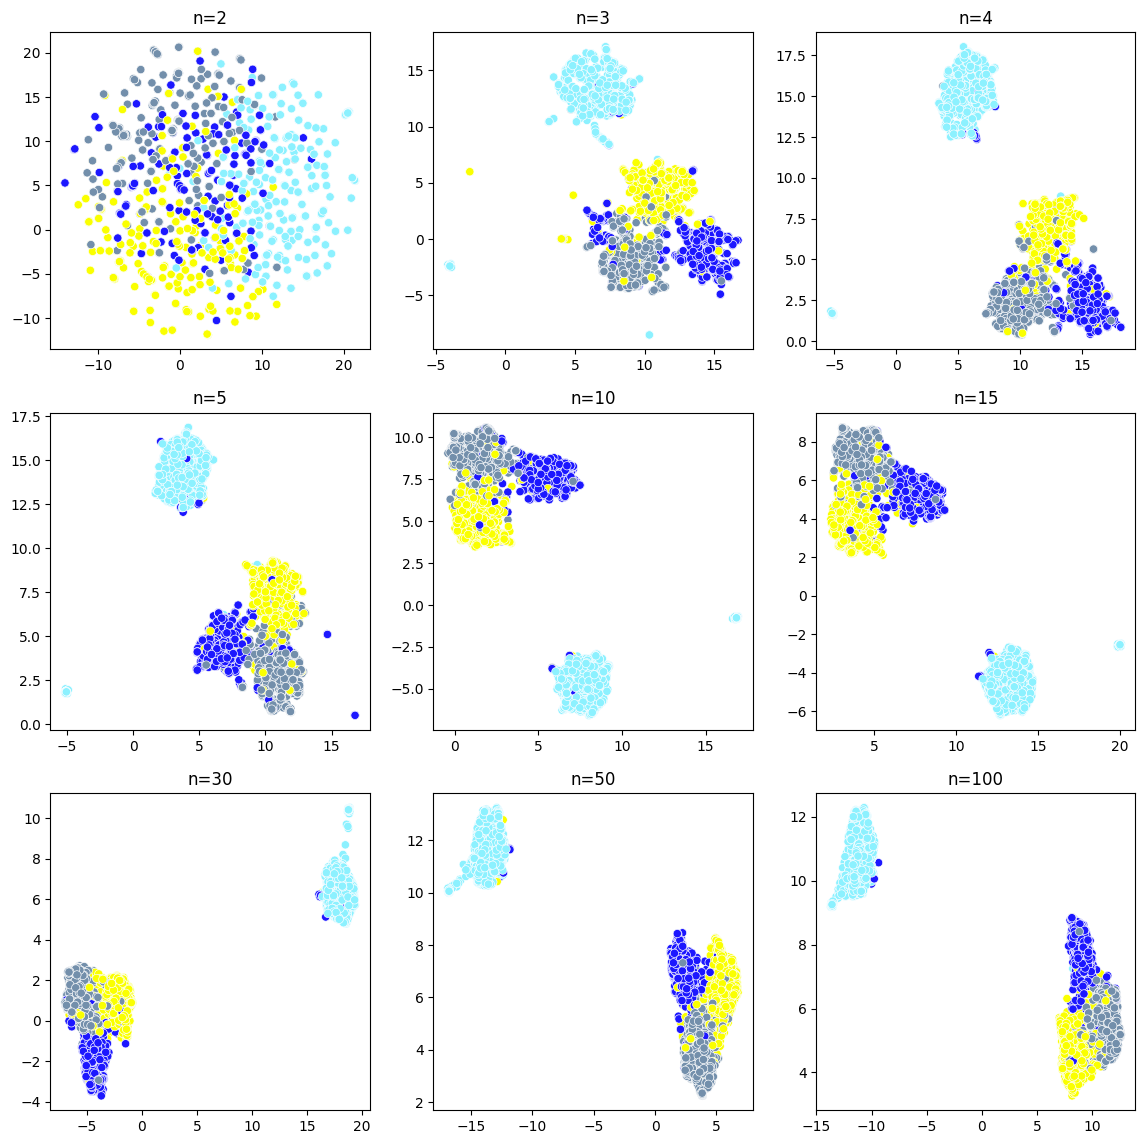

In [13]:
# It took ~2m 7s

import umap
import seaborn as sns


fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nearest_neighbors: list[int] = [2, 3, 4, 5, 10, 15, 30, 50, 100]
i, j = [0, 0]

for n_neighbor in tqdm(nearest_neighbors):
    fit = umap.UMAP(n_neighbors=n_neighbor)
    u = fit.fit_transform(vectors)
    sns.scatterplot(x=u[:, 0], y=u[:, 1], c=colored_sub_reddit, ax=ax[j, i])
    ax[j, i].set_title(f"n={n_neighbor}")
    i += 1
    if i >= 3:  # Reset i and increment j when i exceeds the number of columns (3)
        i = 0
        j += 1

plt.show()

### Comment

- From the visualization above, the model (dimensionality reduction) performs best when `3 <= n_neighbors <= 5`.
- I'll use `n_neighbors=3` and `min_dist=0.05`

In [14]:
import plotly.express as px


palette: list[str] = ["#FAFF00", "#1C17FF", "#738FAB", "#8CF1FF"]
fit = umap.UMAP(
    n_neighbors=4,
    n_components=3,  # N dims
    min_dist=0.05,
)
u = fit.fit_transform(vectors)

fig = px.scatter_3d(
    x=u[:, 0],
    y=u[:, 1],
    z=u[:, 2],
    color=data["sub"],
    custom_data=[data["sub"], data["title"]],
    color_discrete_sequence=palette,
)
fig.update_traces(
    hovertemplate="\n".join(
        [
            "sub: %{customdata[1]}",
            "title: %{customdata[0]}",
        ]
    )
)

<br>

## [Clustering With HDBSCAN](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html)

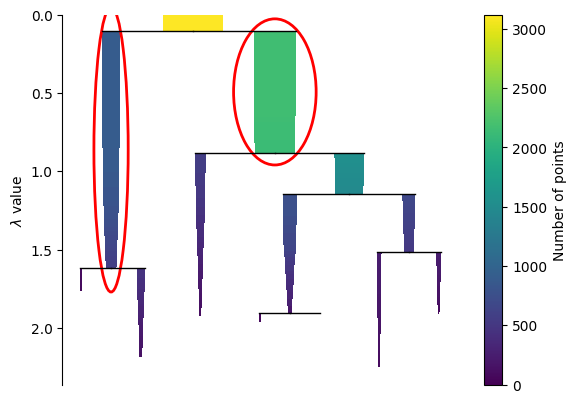

In [15]:
import hdbscan


min_cluster_size: int = 80  # min num of data points per cluster
min_samples: int = 40  # min num of samples in a neighbourhood for a point to be considered a core point.
cluster: hdbscan.HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, min_samples=min_samples
)

# Cluster the data points with reduced dimensions
cluster.fit(u)
cluster.condensed_tree_.plot(select_clusters=True)
plt.show()

In [16]:
import plotly.express as px


colors: list[str] = [str(x) for x in cluster.labels_]

fig = px.scatter_3d(
    x=u[:, 0],
    y=u[:, 1],
    z=u[:, 2],
    color=colors,
    custom_data=[data["sub"], data["title"]],
    color_discrete_sequence=palette,
)
fig.update_traces(
    hovertemplate="\n".join(
        [
            "sub: %{customdata[1]}",
            "title: %{customdata[0]}",
        ]
    )
)

<br>

## [Finding Topics With c-TF-IDF](https://maartengr.github.io/BERTopic/getting_started/ctfidf/ctfidf.html)

- This is an adjusted version of `TF-IDF` representation 
- It takes into account what makes the documents in one cluster different from documents in another cluster

In [17]:
set(cluster.labels_)

{-1, 0, 1}

In [46]:
# Separate the text into the labels defined by HDBSCAN
classes: dict[str, Any] = {}

for label in set(cluster.labels_):
    classes[label] = {"vocab": set(), "tokens": [], "tfidf_array": None}

classes

{0: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 1: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 -1: {'vocab': set(), 'tokens': [], 'tfidf_array': None}}

In [19]:
# Add HDBSCAN to the dataset
data: Dataset = data.add_column("class", cluster.labels_)
data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc', 'class'],
    num_rows: 3118
})

In [20]:
text: str = "My name's Neidu. I'm a data scientist with about 3 years experience. My interests are NLP, data analytics, software engineering, etc."
print(text)

My name's Neidu. I'm a data scientist with about 3 years experience. My interests are NLP, data analytics, software
engineering, etc.

In [21]:
pattern: str = re.compile(r"[^a-zA-Z0-9 ]+")

# Replace pattern with ""
pattern.sub("", text).lower()

'my names neidu im a data scientist with about 3 years experience my interests are nlp data analytics software engineering etc'

In [22]:
def format_text(example: dict[str, Any]) -> dict[str, Any]:
    """This is used to remove punctuations from the data."""
    pattern: str = re.compile(r"[^a-zA-Z0-9\s]+")

    # Replace pattern with ""
    example["tokens"] = [pattern.sub("", x).lower() for x in example.get("selftext")]
    return example

In [23]:
# Test the function
sample_data: Dataset = data.shuffle(seed=123).select(range(10))
sample_data = sample_data.map(format_text, batched=True)


sample_data[:2]["tokens"]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

['i originally asked a question about writing large amounts of data in rlearnpython and was directed towards hdf5  my new question around that format i think might be better suited here  apologies if not\n\nim currently working on a project involving multichannel audio the dataset im using needs to be processed into the desired target signals this takes a database of 64 recordings at around 80gb and prodcues target data of around 5tb i should also add that im taking the 64 recordings and splitting them into 30 second chunks resulting in 1280 recordings in total the size of each chunk after processing is 1440000  x 93\n\nwhats the best way of writing this to a hdf5 file which means i can then utilise dataloader to load data in for training in batches and allows me to access the data in such a way that i can index into the appropriate part of the data to be used for each training example is it best just to have one hdf5 file and have different subfiles within that or should i split it do

In [24]:
# Remove all punctuations and convert to lowercase
data = data.map(format_text, batched=True)
data

Map:   0%|          | 0/3118 [00:00<?, ? examples/s]

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc', 'class', 'tokens'],
    num_rows: 3118
})

In [25]:
print(data[0])

{
    'sub': 'investing',
    'title': 'Who’s adding to their Tesla portfolio before the split?',
    'selftext': '(Reuters) - Tesla Inc on Saturday reported record electric vehicle deliveries for the first 
quarter, driven by a ramp up in production at its Shanghai factory.\nTesla delivered 310,048 vehicles in the 
quarter, while Wall Street had expected deliveries of 308,836 cars, according to Refinitiv data.\nTesla said it 
sold a total of 295,324 Model 3 sedans and Model Y sport utility vehicles.\nIt delivered 14,724 Model S luxury 
sedans and Model X premium SUVs, up from 11,750 in the fourth quarter of 2021.\nAnalysts expected Tesla to deliver 
15,066 Model S and Model X cars and 280,000 Model 3 and Model Y vehicles.',
    'upvote_ratio': 0.38,
    'id': 't3_tvnl5b',
    'created_utc': 1649029616.0,
    'class': 0,
    'tokens': 'reuters  tesla inc on saturday reported record electric vehicle deliveries for the first quarter 
driven by a ramp up in production at its shanghai factory\ntesla delivered 310048 vehicles in the quarter while 
wall street had expected deliveries of 308836 cars according to refinitiv data\ntesla said it sold a total of 
295324 model 3 sedans and model y sport utility vehicles\nit delivered 14724 model s luxury sedans and model x 
premium suvs up from 11750 in the fourth quarter of 2021\nanalysts expected tesla to deliver 15066 model s and 
model x cars and 280000 model 3 and model y vehicles'
}

In [26]:
# Tokenize the data
import spacy


# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

print([token.text for token in doc])

[
    'My',
    'name',
    "'s",
    'Neidu',
    '.',
    'I',
    "'m",
    'a',
    'data',
    'scientist',
    'with',
    'about',
    '3',
    'years',
    'experience',
    '.',
    'My',
    'interests',
    'are',
    'NLP',
    ',',
    'data',
    'analytics',
    ',',
    'software',
    'engineering',
    ',',
    'etc',
    '.'
]

In [27]:
def tokenize_text(example: dict[str, Any]) -> dict[str, Any]:
    """This is used to tokenize the data."""
    nlp = spacy.load("en_core_web_sm")

    tokens: list[str] = example.get("tokens")
    # Tokenize each token in the list separately
    tokenized_tokens = [token.text for token in nlp.pipe(tokens)]
    result: dict[str, Any] = {"tokens": tokenized_tokens}

    return result

In [28]:
[token.text for token in nlp.tokenizer("Hello Neidu! How are ya?")]

['Hello', 'Neidu', '!', 'How', 'are', 'ya', '?']

In [29]:
text: str = """I originally asked a question about writing large amounts of data."""


text_dict: dict[str, Any] = {"tokens": text}
tokenize_text(text_dict)

{'tokens': ['I',
  'originally',
  'asked',
  'a',
  'question',
  'about',
  'writing',
  'large',
  'amounts',
  'of',
  'data',
  '.']}

In [30]:
# It took a whooping 40 mins to run this cell
data = data.map(tokenize_text, batched=False)

Map:   0%|          | 0/3118 [00:00<?, ? examples/s]

In [33]:
print(classes)

{
    0: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
    1: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
    -1: {'vocab': set(), 'tokens': [], 'tfidf_array': None}
}

In [41]:
data[10]["class"]

1

In [47]:
# Add tokenized sentences to the `classes` dict
for row in tqdm(data):
    classes.get(row["class"]).get("tokens").extend(row.get("tokens"))

  0%|          | 0/3118 [00:00<?, ?it/s]

In [50]:
print(classes.get(1).get("tokens")[:8])

['say', 'i', 'wanted', 'to', 'run', 'a', 'hyperparameter', 'search']

### Calculate The c-TFIDF

In [54]:
from spacy.lang.en import stop_words


stop_words: set[str] = stop_words.STOP_WORDS

# Add words
# stop_words.add("\n")

print(list(stop_words)[:5])

['former', 'that', 'would', 'call', 'whenever']

In [55]:
# Remove the stopwords
print(">>> Number of tokens per class <<<")
for cl in tqdm(classes.keys()):
    classes.get(cl)["tokens"] = [
        word for word in classes.get(cl).get("tokens") if word not in stop_words
    ]
    print(f"class({cl}): {len(classes.get(cl).get('tokens'))}")

>>> Number of tokens per class <<<

  0%|          | 0/3 [00:00<?, ?it/s]

class(0): 75469

class(1): 155868

class(-1): 6766

In [56]:
vocab: set[str] = set()

for cl in classes.keys():
    # Entire vocab
    vocab = vocab.union(set(classes.get(cl).get("tokens")))
    # Vocab per class
    classes.get(cl)["vocab"] = set(classes.get(cl).get("tokens"))

#### Calculate The Word Frequency Per Class (TF)


In [57]:
n_classes: int = len(classes.keys())
vocab_size: int = len(vocab)
# Term frequency
tf: np.ndarray = np.zeros((n_classes, vocab_size))

for idx, cl in enumerate(classes.keys()):
    for token_id, term in enumerate(tqdm(vocab)):
        # Num of times the term occurs in the class
        tf[cl, token_id] = classes.get(cl).get("tokens").count(term)

  0%|          | 0/30503 [00:00<?, ?it/s]

  0%|          | 0/30503 [00:00<?, ?it/s]

  0%|          | 0/30503 [00:00<?, ?it/s]

In [58]:
tf

array([[1., 1., 0., ..., 0., 1., 6.],
       [0., 3., 1., ..., 1., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.]])

<br>

#### Calculate IDF

[![image.png](https://i.postimg.cc/kMSvbYzc/image.png)](https://postimg.cc/ThRb80RL)



In [86]:
num_docs: int = 1 # Number of documents
idf: np.ndarray = np.zeros(shape=(num_docs, vocab_size))

# Calculate average number of words per class
A = tf.sum() / tf.shape[0]

for token_id, term in enumerate(tqdm(vocab)):
    # Frequency of term across all classes
    freq_t = tf[:, token_id].sum()
    # Calculate IDF
    idf_score: float = np.log(1 + (A / freq_t))
    idf[:, token_id] = idf_score

  0%|          | 0/30503 [00:00<?, ?it/s]

In [89]:
idf, idf.shape

(array([[11.28185894,  9.89560238, 11.28185894, ..., 11.28185894,
         11.28185894,  8.97938724]]),
 (1, 30503))

In [90]:
tf_idf = tf * idf
tf_idf

array([[11.28185894,  9.89560238,  0.        , ...,  0.        ,
        11.28185894, 53.87632343],
       [ 0.        , 29.68680714, 11.28185894, ..., 11.28185894,
         0.        , 35.91754895],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [94]:
N: int = 5

top_idx: np.ndarray = np.argpartition(tf_idf, -N)[:, -N:]
top_idx

array([[13003, 30466,  6394, 19374, 14802],
       [30428,  3719, 21539,  6394, 19374],
       [ 3315, 18035, 11034,  4728,  4917]])

In [95]:
vlist: list = list(vocab)

for idx, cl in enumerate(classes.keys()):
    topn_idx: np.ndarray = top_idx[idx, :]
    topn_terms: list[str] = [vlist[i] for i in topn_idx]
    print(topn_terms)

['m', 'market', ' ', '\n\n', 'nt']

['model', '\n        ', '\n    ', ' ', '\n\n']

['consider', 'include', 'relevant', 'financial', ' \n ']